# FYI directions, delete later

You are to build upon the predictive analysis (classification) that you already completed in the previous mini-project, adding additional modeling from new classification algorithms as well as more explanations that are inline with the CRISP-DM framework. You should use appropriate cross validation for all of your analysis (explain your chosen method of performance validation in detail). Try to use as much testing data as possible in a realistic manner (you should define what you think
is realistic and why). 

This report is worth 20% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a single document. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered Jupyter notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

Dataset Selection

Select a dataset identically to the way you selected for the first project work week and mini-project.
You are not required to use the same dataset that you used in the past, but you are encouraged.
You must identify two tasks from the dataset to regress or classify. That is:

* two classification tasks OR
* two regression tasks OR
* one classification task and one regression task

For example, if your dataset was from the diabetes data you might try to predict two tasks: (1)
classifying if a patient will be readmitted within a 30 day period or not, and (2) regressing what the
total number of days a patient will spend in the hospital, given their history and specifics of the
encounter like tests administered and previous admittance.

# Lab 2: Zillow Dataset Classification 
MSDS 7331 Data Mining - Section 403 - Lab 2

Team: Ivelin Angelov, Yao Yao, Kaitlin Kirasich, Albert Asuncion

<a id="top"></a>
## Contents
* <a href="#Imports">Imports</a>
* <a href="#Define">Define and Prepare Class Variables</a>
* <a href="#Describe">Describe the Final Dataset</a>
* <a href="#Evaluation">Explain Evaluation Metrics</a>
* <a href="#Splits">Training and Testing Splits</a>
* <a href="#Models">Three Different Classification/Regression Models</a>
* <a href="#Analysis">Visualizations of Results and Analysis</a>
* <a href="#Advantages">Advantages of Each Model</a>
* <a href="#Attributes">Important Attributes</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>
* <a href="#References">References</a>
________________________________________________________________________________________________________
<a id="Imports"></a>
# Imports & Utils

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

def output_variables_table(variables):
    variables = variables.sort_index()
    rows = ['<tr><th>Variable</th><th>Type</th><th>Scale</th><th>Description</th></tr>']
    for vname, atts in variables.iterrows():
        if vname not in dataset.columns:
            continue
        atts = atts.to_dict()
        # add scale if TBD
        if atts['scale'] == 'TBD':
            if atts['type'] in ['nominal', 'ordinal']:
                uniques = dataset[vname].unique()
                uniques = list(uniques.astype(str))
                if len(uniques) < 10:
                    atts['scale'] = '[%s]' % ', '.join(uniques)
                else:
                    atts['scale'] = '[%s]' % (', '.join(uniques[:5]) + ', ... (%d More)' % len(uniques))
            if atts['type'] in ['ratio', 'interval']:
                atts['scale'] = '(%d, %d)' % (dataset[vname].min(), dataset[vname].max())
        row = (vname, atts['type'], atts['scale'], atts['description'])
        rows.append('<tr><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>' % row)
    return HTML('<table>%s</table>' % ''.join(rows))


# Define an accuracy plot
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue, yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
# Plot the feature importances of the forest
def plot_feature_importance(ytrue,yhat,rt, title=''):
    importances = rt.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rt.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
def print_accuracy(model_name, y_test, yhat):
    print('----------------- %s Evaluation -----------------' % model_name)
    print(' Accuracy', mt.accuracy_score(y_test, yhat))
    prf = mt.precision_recall_fscore_support(y_test, yhat, average='macro')
    print(' Precision', prf[0])
    print(' Recall', prf[1])
    print(' F-measure', prf[2])
    plot_class_acc(y_test, yhat, title=model_name + " Raw")
    
def confusion_matrix(ytrue, yhat, classes):
    index = pd.MultiIndex.from_product([['True Class'], classes])
    columns = pd.MultiIndex.from_product([['Predicted Class'], classes])
    return pd.DataFrame(mt.confusion_matrix(y, yhat), index=index, columns=columns)
    
def get_dataset_subset(dataset, n=1000):
    return {
        'X': dataset['X'].iloc[:n],
        'y': dataset['y'].iloc[:n]
    }

<a href="#top">Back to Top</a>
<a id="Define"></a>
# Define and Prepare Class Variables
<b>10 points</b>

<i>
<b>Description:</b><br/>
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
</i>

## Classification Dataset

In [2]:
variables = pd.read_csv('../../datasets/variables.csv').set_index('name')
dataset = pd.read_csv('../../datasets/train.csv', low_memory=False)

# remove unneeded variables
del dataset['logerror']
del dataset['transactiondate']
del dataset['city']
del dataset['price_per_sqft']


# delete all location information because we want to predict the couty
# and those feature will give it up to easy
y = dataset['regionidcounty'].copy()
del dataset['regionidcounty']
del dataset['regionidcity']
del dataset['regionidzip']
del dataset['regionidneighborhood']
del dataset['rawcensustractandblock']
del dataset['latitude']
del dataset['longitude']

output_variables = output_variables_table(variables)

nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(dataset.columns)]
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(dataset.columns)]

nominal_data = dataset[nominal.index]
nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

continuous_data = dataset[continuous.index]

dataset = pd.concat([continuous_data, nominal_data], axis=1)

columns = dataset.columns
variables = variables[variables.index.isin(dataset.columns)]

# shuffle the dataset (just in case)
dataset = dataset.sample(frac=1)

X = dataset
dataset_class = {
    'X': X,
    'y': y
}
print(y.groupby(y).size())
output_variables

regionidcounty
1286    35417
2061    10261
3101    71083
Name: regionidcounty, dtype: int64


Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[0, 1, 5, 13, 11, 9, 3]",Type of cooling system present in the home (if any)
assessmentyear,interval,"(2015, 2015)",The year of the property tax assessment
bathroomcnt,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[3, 2, 4, 5, 6, ... (17 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[7, 4, 10, 1, 8, 12, 6, 11]",Overall assessment of condition of the building from best (lowest) to worst (highest)
calculatedbathnbr,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathroom
calculatedfinishedsquarefeet,ratio,"(0, 10925)",Calculated total finished living area of the home
censustractandblock,nominal,"[61110023618600.0, 61110015230000.0, 61110006841300.0, 61110052978700.0, 61110040395800.0, ... (445 More)]",Census tract and block ID combined - also contains blockgroup assignment by extension
finishedsquarefeet12,ratio,"(0, 6615)",Finished living area
finishedsquarefeet50,ratio,"(0, 8352)",Size of the finished living area on the first (entry) floor of the home


## Regression Dataset

In this dataset we will predict the value of taxamount

Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[0, 1, 5, 13, 11, 9, 3]",Type of cooling system present in the home (if any)
assessmentyear,interval,"(2015, 2015)",The year of the property tax assessment
bathroomcnt,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[3, 2, 4, 5, 6, ... (17 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[7, 4, 10, 1, 8, 12, 6, 11]",Overall assessment of condition of the building from best (lowest) to worst (highest)
calculatedbathnbr,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathroom
calculatedfinishedsquarefeet,ratio,"(0, 10925)",Calculated total finished living area of the home
censustractandblock,nominal,"[61110023618600.0, 61110015230000.0, 61110006841300.0, 61110052978700.0, 61110040395800.0, ... (445 More)]",Census tract and block ID combined - also contains blockgroup assignment by extension
finishedsquarefeet12,ratio,"(0, 6615)",Finished living area
finishedsquarefeet50,ratio,"(0, 8352)",Size of the finished living area on the first (entry) floor of the home


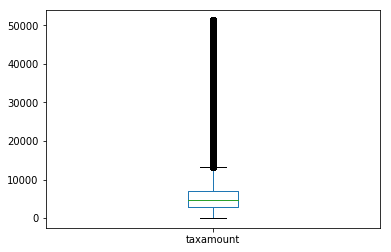

In [3]:
variables = pd.read_csv('../../datasets/variables.csv').set_index('name')
dataset = pd.read_csv('../../datasets/train.csv', low_memory=False)

# remove unneeded variables
del dataset['logerror']
del dataset['transactiondate']
del dataset['city']
del dataset['price_per_sqft']

output_variables = output_variables_table(variables)

nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(dataset.columns)]
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(dataset.columns)]

nominal_data = dataset[nominal.index]
nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

continuous_data = dataset[continuous.index]

dataset = pd.concat([continuous_data, nominal_data], axis=1)

columns = dataset.columns
variables = variables[variables.index.isin(dataset.columns)]

# shuffle the dataset (just in case)
dataset = dataset.sample(frac=1)

X = dataset
y = X['taxamount'].copy()
del X['taxamount']
# del X['taxvaluedollarcnt']????

dataset_reg = {
    'X': X,
    'y': y
}
y.plot(kind='box')
output_variables

In [4]:
dataset_class = get_dataset_subset(dataset_class, 1000)
dataset_reg = get_dataset_subset(dataset_reg, 5000)

<a href="#top">Back to Top</a>
<a id="Describe"></a>
# Describe the Final Dataset
<b>5 points</b>

<i>
<b>Description:</b><br/>
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
</i>

<a href="#top">Back to Top</a>
<a id="Evaluation"></a>
# Explain Evaluation Metrics
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</i>

For our evaluation, we will be taking into account the accuracy and F-measure.  In order to compute the F-measure, we will need the precision and recall.  Because F-measure is a weighted average of these, we think a better F-measure score means the model has a better precision and recall.

Accuracy is the ratio of correct predictions to the total number of observations. It is calculated as: (TP+TN) / (TP+FP+FN+TN). The closer accuracy is to 1, the more accurate the model is, with one caveat. For high accuracy to be a reliable indicator, the dataset has to be symmetric, i.e. total false positives are about equal to false negatives. Otherwise, we need to review other parameters as well.

Precision is the ratio of correctly predicted positive observations to the total positive observations. It is calculated as: TP / (TP+FP).  

Recall is the ratio of correctly predicted positive observations to all actual positives. It is calculated as TP / (TP+FN). The consequences of type 2 errors, predicting a false negative, are not extreme so we think recall is an appropriate measure of completeness.

Finally, we will also use F-measure which is essentially a weighted average of the precision and recall into one simple statistic. F-measure This will be a number between 0 and 1 where closer to 1 is better and approaching 0 is worse. It overcomes the limitations of accuracy whenever false positives and false negatives are not about equal or symmetric.

<a href="#top">Back to Top</a>
<a id="Imports"></a>
# Training and Testing Splits
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</i>

# TODO build chart of train size while accuracy continues to increase

We have a large dataset so 10 fold cross validation may take too long.  Because of this, we will be splitting our dataset into 80% train and 20% test.

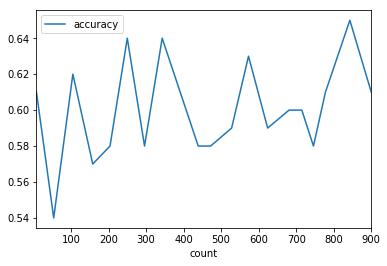

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt

X = dataset_class['X']
y = dataset_class['y']
X, X_test, y, y_test = train_test_split(X, y, test_size=.1, random_state=0)

result = []

# uniform distribution values between 0 and 1
mask = np.random.rand(len(X))

for frac in np.linspace(.01, 1, 20):
    mask_frac = mask<=frac
    X_frac = X[mask_frac]
    y_frac = y[mask_frac]

    clf = RandomForestClassifier()
    clf.fit(X_frac, y_frac)
    y_hat = clf.predict(X_test)
    
    result.append({
        'accuracy': mt.accuracy_score(y_test, y_hat),
        'count': len(X_frac),
        'frac': frac
    })

pd.DataFrame(result).plot('count', 'accuracy')

<a href="#top">Back to Top</a>
<a id="Models"></a>
# Three Different Classification/Regression Models
<b>20 points</b>

<i>
<b>Description:</b><br/>
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</i>

## Kaitlin - 3 classification models

# Dummy model
This model is only predicting the most frequent class. It is used for a base line.

----------------- Dummy Evaluation -----------------
 Accuracy 0.69
 Precision 0.23
 Recall 0.333333333333
 F-measure 0.272189349112


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


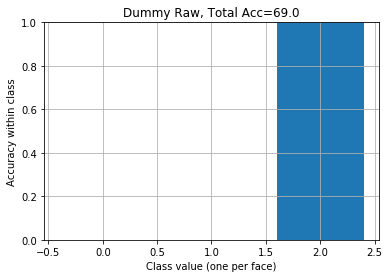

In [6]:
print_accuracy('Dummy', y, [3101] * len(y))

# KNN

n_neighbors: 1 accuracy: 0.531
n_neighbors: 2 accuracy: 0.423
n_neighbors: 3 accuracy: 0.55
n_neighbors: 4 accuracy: 0.545
n_neighbors: 5 accuracy: 0.582
n_neighbors: 6 accuracy: 0.605
n_neighbors: 7 accuracy: 0.627
n_neighbors: 8 accuracy: 0.631
n_neighbors: 9 accuracy: 0.641
n_neighbors: 10 accuracy: 0.648
n_neighbors: 11 accuracy: 0.664
Accuracy: 0.59 (+/- 0.13)
----------------- KNeighborsClassifier Evaluation -----------------
 Accuracy 0.664
 Precision 0.404139696648
 Recall 0.343333654914
 F-measure 0.314485594192


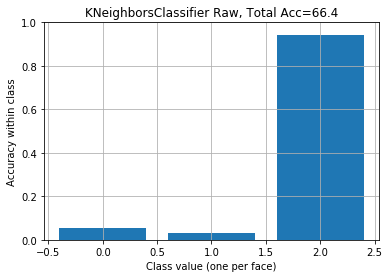

Predicted Class          
                           1286 2061 3101
True Class 1286              12    2  200
           2061               3    3   92
           3101              33    6  649

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold

scores = []
for n_neighbors in range(1, 12):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    accuracy = mt.accuracy_score(y, yhat)
    print ('n_neighbors:', n_neighbors, 'accuracy:', accuracy)
    scores.append(accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('KNeighborsClassifier', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

n_neighbors: 1 accuracy: 0.548888888889
n_neighbors: 2 accuracy: 0.414444444444
n_neighbors: 3 accuracy: 0.58
n_neighbors: 4 accuracy: 0.565555555556
n_neighbors: 5 accuracy: 0.583333333333
n_neighbors: 6 accuracy: 0.607777777778
n_neighbors: 7 accuracy: 0.633333333333
n_neighbors: 8 accuracy: 0.635555555556
n_neighbors: 9 accuracy: 0.642222222222
n_neighbors: 10 accuracy: 0.653333333333
n_neighbors: 11 accuracy: 0.666666666667
Accuracy: 0.59 (+/- 0.13)
----------------- KNeighborsClassifier Evaluation -----------------
 Accuracy 0.666666666667
 Precision 0.339933166249
 Recall 0.334950580265
 F-measure 0.29730538211


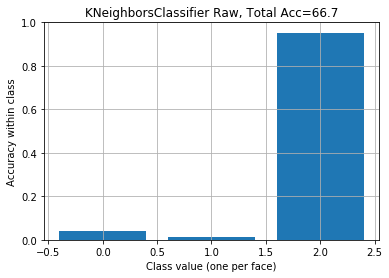

Predicted Class          
                           1286 2061 3101
True Class 1286               8    3  181
           2061               3    1   83
           3101              24    6  591

In [8]:
# Duplicate KNN for optimazations
# Remove for final
scores = []
for n_neighbors in range(1, 12):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, p=3)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    accuracy = mt.accuracy_score(y, yhat)
    print ('n_neighbors:', n_neighbors, 'accuracy:', accuracy)
    scores.append(accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('KNeighborsClassifier', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

## Optimizing KNN
<b>Weights</b><br>
weights='uniform' Accuracy: 0.59 (+/- 0.15)<br>
weights='distance' Accuracy: 0.60 (+/- 0.09)<br>

<b>Algorithm</b><br>
algorithm='auto' Accuracy: 0.59 (+/- 0.15)<br>
algorithm='ball_tree' Accuracy: 0.59 (+/- 0.15)<br>
algorithm='kd_tree' Accuracy: 0.59 (+/- 0.15)<br>
algorithm='brute' Accuracy: 0.59 (+/- 0.15)<br>

<b>Leaf Size</b><br>
leaf_size in range 1 to 12, accuracy always 0.668888888889<br>

<b>P</b><br>
p=1 Accuracy: 0.59 (+/- 0.15)<br>
p=2 Accuracy: 0.59 (+/- 0.14)<br>
p=3 Accuracy: 0.59 (+/- 0.15)<br>

max_depth: 1.0 accuracy: 0.69
max_depth: 2.9 accuracy: 0.69
max_depth: 4.8 accuracy: 0.691111111111
max_depth: 6.7 accuracy: 0.69
max_depth: 8.6 accuracy: 0.69
max_depth: 10.5 accuracy: 0.687777777778
max_depth: 12.4 accuracy: 0.687777777778
max_depth: 14.3 accuracy: 0.69
max_depth: 16.2 accuracy: 0.684444444444
max_depth: 18.1 accuracy: 0.683333333333
max_depth: 20.0 accuracy: 0.68
Accuracy: 0.69 (+/- 0.01)
----------------- RandomForestClassifier Evaluation -----------------
 Accuracy 0.68
 Precision 0.3004784689
 Recall 0.333299785293
 F-measure 0.282680424741


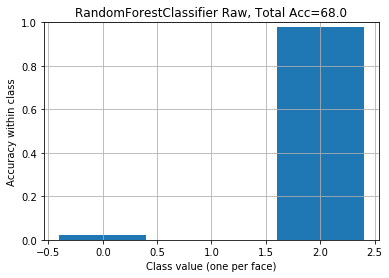

Predicted Class          
                           1286 2061 3101
True Class 1286               4    0  188
           2061               3    0   84
           3101              12    1  608

In [9]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

scores = []
for max_depth in np.linspace(1, 20, 11):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = RandomForestClassifier(max_depth=max_depth)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    accuracy = mt.accuracy_score(y, yhat)
    print ('max_depth:', max_depth, 'accuracy:', accuracy)
    scores.append(accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('RandomForestClassifier', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

n_estimators: 4 accuracy 0.562222222222
n_estimators: 5 accuracy 0.581111111111
n_estimators: 6 accuracy 0.606666666667
n_estimators: 7 accuracy 0.6
n_estimators: 8 accuracy 0.616666666667
n_estimators: 9 accuracy 0.631111111111
n_estimators: 10 accuracy 0.64
n_estimators: 11 accuracy 0.631111111111
n_estimators: 12 accuracy 0.641111111111
n_estimators: 13 accuracy 0.643333333333
n_estimators: 14 accuracy 0.645555555556
Accuracy: 0.62 (+/- 0.05)
----------------- RandomForestClassifier Evaluation -----------------
 Accuracy 0.645555555556
 Precision 0.291159123363
 Recall 0.326254696726
 F-measure 0.293279982647


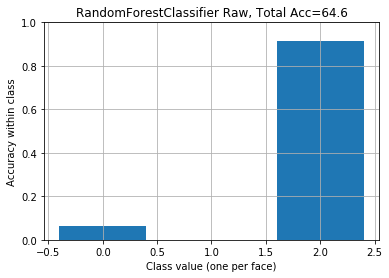

Predicted Class          
                           1286 2061 3101
True Class 1286              12    1  179
           2061               9    0   78
           3101              44    8  569

In [10]:
# Duplicate random forest section for optimizing 
# Remove for final 
scores = []
for n_estimators in range(4,15):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = RandomForestClassifier(n_estimators=n_estimators)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    accuracy = mt.accuracy_score(y, yhat)
    print ('n_estimators:', n_estimators, 'accuracy', accuracy)
    scores.append(accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('RandomForestClassifier', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

## Optimizing Random Forest
We found that tinkering with max_depth was the best way to test our scores.  

<b>Close to no difference in scores:</b><br>
min_samples_split values from 2 to 10 all produced scores of about 0.69 (+/- 0.01).<br>
criterion="gini" produced accuracy scores around 0.69 (+/- 0.01)<br>
criterion="entropy" produced accuracy scores around 0.69 (+/- 0.01)<br>
min_samples_leaf values 3 or greater all produced scores of 0.69 across the board.<br>
min_weight_fraction_leaf linearly stepping through 0.001 to 0.5 produced scores of 0.69 across the board.<br>
min_impurity_decrease produced accuracy scores around 0.69 (+/- 0.01)<br>
warm_start='true' vs warm_start='false' produced accuracy scores around 0.69 (+/- 0.01)<br>

<b>We did try the following but got fairly low scores and removed them from our final model:</b><br>
class_weight="balanced_subsample" produced accuracy scores around 0.49 (+/- 0.23)<br>
class_weight="balanced" produced accuracy scores around 0.50 (+/- 0.18)<br>
max_depth ranges 4 to 15 produced accuracy scores around Accuracy: 0.64 (+/- 0.04)

# Feature importance of Random Forest

Random Forest Feature ranking:
1. feature 22 (0.073674)
2. feature 23 (0.069536)
3. feature 4 (0.065906)
4. feature 25 (0.063267)
5. feature 5 (0.060283)
6. feature 20 (0.060048)
7. feature 26 (0.059021)
8. feature 12 (0.057670)


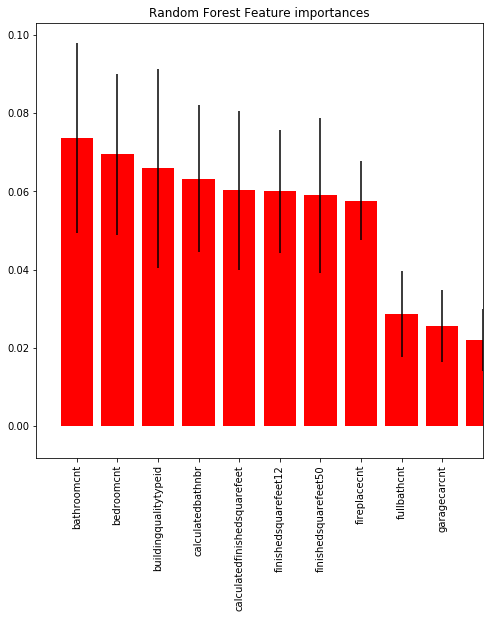

In [11]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Random Forest Feature ranking:")
for f in range(X.shape[1]):
    if importances[indices[f]] > 0.05:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8,8))
plt.title("Random Forest Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
feature_names = X.columns
plt.xticks(range(10), feature_names)
plt.xticks(rotation=90)
plt.xlim([-1, 10])
plt.show()

alpha: 0.001 accuracy: 0.402222222222
alpha: 0.112 accuracy: 0.402222222222
alpha: 0.223 accuracy: 0.402222222222
alpha: 0.334 accuracy: 0.402222222222
alpha: 0.445 accuracy: 0.402222222222
alpha: 0.556 accuracy: 0.402222222222
alpha: 0.667 accuracy: 0.402222222222
alpha: 0.778 accuracy: 0.402222222222
alpha: 0.889 accuracy: 0.402222222222
alpha: 1.0 accuracy: 0.404444444444
Accuracy: 0.40 (+/- 0.00)
----------------- MultinomialNB Evaluation -----------------
 Accuracy 0.404444444444
 Precision 0.368780634502
 Recall 0.376413645029
 F-measure 0.333926895628


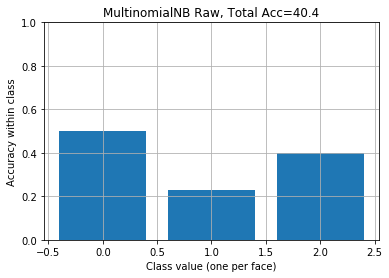

Predicted Class          
                           1286 2061 3101
True Class 1286              96   40   56
           2061              39   20   28
           3101             242  131  248

In [12]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

scores = []
for alpha in np.linspace(0.001, 1.0, 10):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = MultinomialNB(alpha=alpha, fit_prior='false')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    accuracy = mt.accuracy_score(y, yhat)
    print ('alpha:', alpha, 'accuracy:', accuracy)
    scores.append(accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('MultinomialNB', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

## Optimizing Naive Bayes

<b>Type</b><br>
MultinomialNB Accuracy: 0.48 (+/- 0.00)<br>
GaussianNB Accuracy: 0.24 (+/- 0.00)<br>
BernoulliNB Accuracy: 0.67 (+/- 0.08)<br>

<b>Fit Prior</b><br>
For MultinomialNB, fit_prior='false' vs fit_prior='true' had no difference Accuracy: 0.48 (+/- 0.00)<br>
For BernoulliNB, fit_prior='false' vs fit_prior='true' had no difference Accuracy: 0.67 (+/- 0.08)

<a href="#top">Back to Top</a>
<a id="Analysis"></a>
# Visualizations of Results and Analysis
<b>10 points</b>

<i>
<b>Description:</b><br/>
Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</i>

# Analysis of Classification model
We choose for a best classification model a Random Forest

----------------- RandomForestClassifier Evaluation -----------------
 Accuracy 0.621111111111
 Precision 0.31423087569
 Recall 0.324633111685
 F-measure 0.304119081333


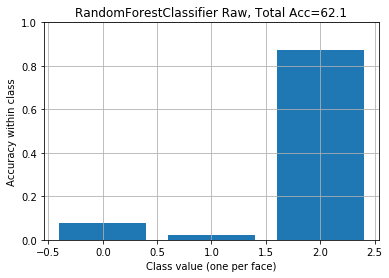

Predicted Class          
                           1286 2061 3101
True Class 1286              15    5  172
           2061              10    2   75
           3101              62   17  542

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
    
yhat = np.zeros(len(y))
yhat_score = np.zeros((len(y), 3))

cv = StratifiedKFold(n_splits=5)
for train_index, test_index in cv.split(X, y):
    clf = RandomForestClassifier()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)
    yhat_score[test_index] = clf.predict_proba(X_test)

print_accuracy('RandomForestClassifier', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

## ROC Curve

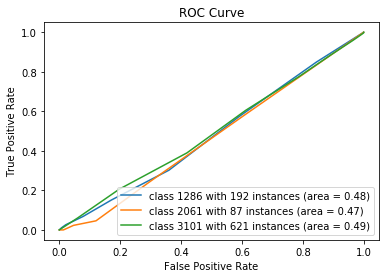

In [14]:
for i, label in enumerate(clf.classes_):
    fpr, tpr, _ = mt.roc_curve(y, yhat_score[:, i], pos_label=label)
    roc_auc = mt.auc(fpr, tpr)

    plt.plot(fpr, tpr, label='class {0} with {1} instances (area = {2:0.2f})'
                                   ''.format(label, sum(y==label), roc_auc))

plt.title('ROC Curve')
plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We choose for a best regression model a Random Forest

R2: 0.9107116934
mean_squared_error: 3559465.596


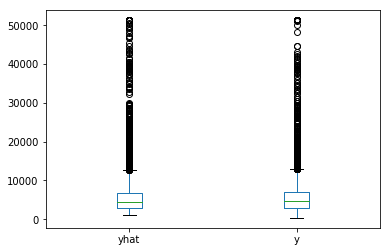

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold

X = dataset_reg['X']
y = dataset_reg['y']

yhat = np.zeros(y.shape) # we will fill this with predictions
cv = KFold(n_splits=10)
for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reg = RandomForestRegressor(max_depth=10)
    reg.fit(X_train, y_train)
    yhat[test_index] = reg.predict(X_test)

print('R2:', mt.r2_score(y, yhat))
print('mean_squared_error:', mt.mean_squared_error(y, yhat))

result = pd.DataFrame(yhat, columns=['yhat'])
result['y'] = y.values
result.plot(kind='box');

<a href="#top">Back to Top</a>
<a id="Advantages"></a>
# Advantages of Each Model
<b>10 points</b>

<i>
<b>Description:</b><br/>
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</i>

<a href="#top">Back to Top</a>
<a id="Attributes"></a>
# Important Attributes
<b>10 points</b>

<i>
<b>Description:</b><br/>
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</i>

<a href="#top">Back to Top</a>
<a id="Deployment"></a>
# Deployment
<b>5 points</b>

<i>
<b>Description:</b><br/>
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</i>

Zillow is at the forefront of real estate data analytics, refining its proprietary Zestimate price calculation tool since 2006. According to Steph Humphries, Chief Analytics Officer & Economist, Zillow’s goal is to provide buyers and sellers with valuation that “starts the conversation”. He noted that since Zillow began offering publicly available real estate data from disparate sources into a single platform, the gap between sellers’ prices and buyers’ offer prices has significantly decreased.

The Zillow dataset was provided for the purpose of evaluating Zestimate’s accuracy based upon the variable `logerror` which is the difference of log(Zestimate) - log(SalePrice). For purposes of this lab assignment, we developed regression and classification models on the `regionidcounty` field (i.e. the county identifier). ****** TODO Insert insights form regression and classification models here *******

For companies in the real estate space, classification models based on “hedonic” (i.e. physical characteristics) attributes provide valuable insight for buying, selling, and investment decisions. Our classification model can be adapted to more granular levels as cities and municipalities. Buyers, sellers, and investors alike can glean insights into which hedonic features have the highest importance to specific locations. This may drive investment decisions knowing how important certain attributes are for targeted locations. Knowing which features are highly important in certain locations can drive remodeling decisions to make properties more attractive to potential buyers. The value-add of this model for these companies can be measured in terms of returns on investment.

This can be valuable for the rental market as well, as Humphries explains Zillow’s collaborations with Airbnb. Airbnb can direct marketing efforts to areas with specific property attributes. This can also be used to provide the break-even horizon for making rent versus own decisions. 

In addition, loan refinancing companies can utilize this model along with Zillow’s liens and taxes database to target homeowners in specific areas. To track effectiveness of marketing campaigns based on this model, response rates can be tracked as well as conversion rates.

To further improve the effectiveness of the model, we should expand the model to include sales prices, liens, taxes, as well as identify biased data such as short sales, foreclosures, and “arms-length” transactions (i.e. sales to relatives). All these are readily available from Zillow, as they collect an enormous amount of data which we imagine is updated frequently. Humphries put in context when he said, Zillow started with 34,000 statistical models per month in 2006, they now generate between 7 and 8 million models every night.

Reference: http://www.zdnet.com/article/zillow-machine-learning-and-data-in-real-estate/


<a href="#top">Back to Top</a>
<a id="Exceptional"></a>
# Exceptional Work
<b>10 points</b>

<i>
<b>Description:</b><br/>
You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
</i>

## Show two dimentional Linear Discriminant Analysis
The idea is to see if there are separatable clusters by class

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


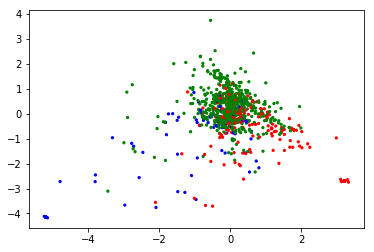

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = dataset_class['X']
y = dataset_class['y']

lde = LDA(n_components=2)
X_lde = lde.fit(X, y).transform(X)

colors = y.astype(str)
colors[colors=='3101'] = 'g'
colors[colors=='2061'] = 'b'
colors[colors=='1286'] = 'r'

plt.scatter(X_lde[:, 1], X_lde[:, 0], s=5, c=colors)

<a href="#top">Back to Top</a>
<a id="References"></a>
# References:

- Kernels from Kaggle competition: https://www.kaggle.com/c/zillow-prize-1/kernels
- Scikitlearn logistic regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Scikitlearn linear SVC: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- Stackoverflow pandas questions: https://stackoverflow.com/questions/tagged/pandas